In [ ]:
import pandas as pd
import numpy as np

In [ ]:
purchases = pd.read_excel("/content/Purchases.xlsx")

In [ ]:
purchases.head()

,Cust ID,Purchase Amount,Date of Purchase
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09
4,1940,70.0,2013-01-25


# Convert 'Date of Purchase' to datetime and calculate 'days since'

In [ ]:
purchases['Date of Purchase'] = pd.to_datetime(purchases['Date of Purchase'])
reference_date = pd.Timestamp('2016-01-01')
purchases['days_since'] = (reference_date - purchases['Date of Purchase']).dt.days



# Calculate frequency for each unique 'cust ID'

In [ ]:
purchases['frequency'] = purchases.groupby('Cust ID')['Cust ID'].transform('count')


# Calculate average monetary value

In [ ]:
purchases['average_monetary_value'] = purchases.groupby('Cust ID')['Purchase Amount'].transform('sum') / purchases['frequency']


# Calculate 'first purchased' and 'recency' for each 'cust ID'

In [ ]:
purchases['first_purchased'] = purchases.groupby('Cust ID')['days_since'].transform('max')
purchases['recency'] = purchases.groupby('Cust ID')['days_since'].transform('min')

# Display the modified dataframe

In [ ]:
purchases.head()

,Cust ID,Purchase Amount,Date of Purchase,days_since,frequency,average_monetary_value,first_purchased,recency
0,760,25.0,2009-11-06,2247,5,38.000000,3293,1273
1,860,50.0,2012-09-28,1190,10,54.000000,4008,237
2,1200,100.0,2005-10-25,3720,9,102.777778,3907,1192
3,1420,50.0,2009-07-09,2367,34,51.029412,3810,24
4,1940,70.0,2013-01-25,1071,10,47.500000,3957,686


# Droping of (Purchase Amount,Date of Purchase,days_since) columns

In [ ]:
purchases.drop(columns=['Purchase Amount','Date of Purchase','days_since'],inplace=True)

In [ ]:
purchases = purchases.drop_duplicates()
purchases

,Cust ID,frequency,average_monetary_value,first_purchased,recency
0,760,5,38.000000,3293,1273
1,860,10,54.000000,4008,237
2,1200,9,102.777778,3907,1192
3,1420,34,51.029412,3810,24
4,1940,10,47.500000,3957,686
...,...,...,...,...,...
51195,251870,1,30.000000,78,78
51202,254130,1,60.000000,63,63
51206,85740,1,30.000000,2977,2977
51221,78290,1,10.000000,3087,3087


# Calculate quantiles for recency, frequency, and average_monetary_value

In [ ]:

quantiles = purchases[['recency', 'frequency', 'average_monetary_value']].quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

print(quantiles)

{'recency': {0.25: 244.0, 0.5: 1070.0, 0.75: 2130.0}, 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0}, 'average_monetary_value': {0.25: 21.666666666666668, 0.5: 30.0, 0.75: 50.0}}


# Perform RFM scoring

In [ ]:

def rfm_scoring(df):
    # Recency score
    df['R'] = df['recency'].apply(lambda x: 1 if x > 730 else (2 if x > 365 else 3))

    # Frequency score
    df['F'] = df['frequency'].apply(lambda x: 1 if x == 1 else (2 if x <= 3 else 3))

    # Monetary score
    df['M'] = df['average_monetary_value'].apply(lambda x: 1 if x <= 20 else (2 if x <= 50 else 3))

    # Calculate RFM score
    df['RFM_score'] = df['R'] * 100 + df['F'] * 10 + df['M']

    return df

# Apply the scoring function
purchases = rfm_scoring(purchases)

# Display the result
purchases

,Cust ID,frequency,average_monetary_value,first_purchased,recency,R,F,M,RFM_score
0,760,5,38.000000,3293,1273,1,3,2,132
1,860,10,54.000000,4008,237,3,3,3,333
2,1200,9,102.777778,3907,1192,1,3,3,133
3,1420,34,51.029412,3810,24,3,3,3,333
4,1940,10,47.500000,3957,686,2,3,2,232
...,...,...,...,...,...,...,...,...,...
51195,251870,1,30.000000,78,78,3,1,2,312
51202,254130,1,60.000000,63,63,3,1,3,313
51206,85740,1,30.000000,2977,2977,1,1,2,112
51221,78290,1,10.000000,3087,3087,1,1,1,111


In [ ]:
purchases['RFM_score'].value_counts()

RFM_score
112    3304
111    2394
122    1759
332    1296
113     985
333     984
121     778
322     762
132     738
312     726
123     587
212     491
323     445
313     407
133     338
311     331
222     306
331     287
232     286
211     220
213     190
131     178
223     162
321     160
233     158
221      82
231      63
Name: count, dtype: int64

# Ploting RFM Scores Distribution

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Data
rfm_scores = {
    '112': 3304, '111': 2394, '122': 1759, '332': 1296, '113': 985, '333': 984,
    '121': 778, '322': 762, '132': 738, '312': 726, '123': 587, '212': 491,
    '323': 445, '313': 407, '133': 338, '311': 331, '222': 306, '331': 287,
    '232': 286, '211': 220, '213': 190, '131': 178, '223': 162, '321': 160,
    '233': 158, '221': 82, '231': 63
}

# Convert the dictionary to lists
rfm_labels = list(rfm_scores.keys())
rfm_values = list(rfm_scores.values())

# Assign a unique color to each bar
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
    '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7',
    '#dbdb8d', '#9edae5', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2'
]

# Create a bar graph
fig = go.Figure(data=[go.Bar(x=rfm_labels, y=rfm_values, marker_color=colors)])

# Customize the layout
fig.update_layout(
    title='RFM Scores Distribution',
    xaxis_title='RFM Score',
    yaxis_title='Frequency',
    xaxis_tickangle=-45
)

# Show the figure
pio.show(fig)

# Ploting Customer Segments and Their Sizes

Segment Sizes (Sorted):
Segment
At Risk                5650
Lost                   4157
Loyal Customers        2505
Recent Customers       2343
About to Sleep         1254
Champions               984
Promising               655
Need Attention          491
Potential Loyalists     158
Name: Count, dtype: int64


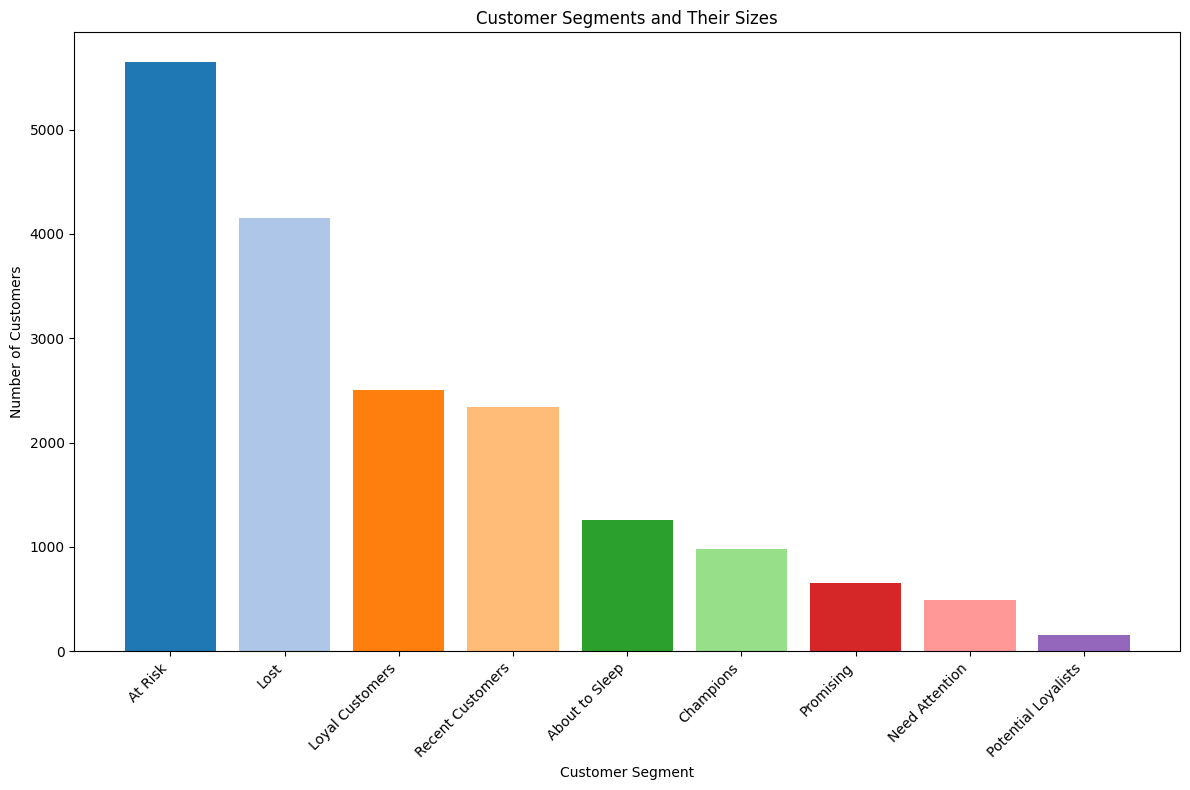

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the RFM score counts
rfm_counts = {
    'RFM_score': ['112', '111', '122', '332', '113', '333', '121', '322', '132', '312',
                  '123', '212', '323', '313', '133', '311', '222', '331', '232', '211',
                  '213', '131', '223', '321', '233', '221', '231'],
    'Count': [3304, 2394, 1759, 1296, 985, 984, 778, 762, 738, 726,
              587, 491, 445, 407, 338, 331, 306, 287, 286, 220,
              190, 178, 162, 160, 158, 82, 63]
}

# Create DataFrame for RFM counts
rfm_df = pd.DataFrame(rfm_counts)

# Define the mapping of RFM scores to segments
segment_mapping = {
    '333': 'Champions',
    '332': 'Loyal Customers',
    '331': 'Loyal Customers',
    '322': 'Loyal Customers',
    '321': 'Loyal Customers',
    '233': 'Potential Loyalists',
    '313': 'Recent Customers',
    '323': 'Recent Customers',
    '312': 'Recent Customers',
    '311': 'Recent Customers',
    '223': 'Recent Customers',
    '221': 'Recent Customers',
    '213': 'Recent Customers',
    '232': 'Promising',
    '231': 'Promising',
    '222': 'Promising',
    '212': 'Need Attention',
    '132': 'About to Sleep',
    '131': 'About to Sleep',
    '133': 'About to Sleep',
    '123': 'At Risk',
    '122': 'At Risk',
    '112': 'At Risk',
    '113': 'Lost',
    '111': 'Lost',
    '121': 'Lost'
}

# Map RFM scores to segments
rfm_df['Segment'] = rfm_df['RFM_score'].map(segment_mapping)

# Aggregate counts by segment
segment_counts = rfm_df.groupby('Segment')['Count'].sum()

# Sort segment_counts by size in descending order
segment_counts = segment_counts.sort_values(ascending=False)

# Print the sorted table of segment sizes
print("Segment Sizes (Sorted):")
print(segment_counts)

# Plot the sorted segment sizes
plt.figure(figsize=(12, 8))
colors = plt.get_cmap('tab20').colors  # Use a colormap with many distinct colors

# Ensure the number of colors matches the number of segments
color_list = colors[:len(segment_counts)]

plt.bar(segment_counts.index, segment_counts.values, color=color_list)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Segments and Their Sizes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

# Performing Customer Segmentation

In [ ]:
# Define segmentation function
def segment_customer(row):
    if row['recency'] > 1095:
        return 'Inactive'
    elif 1095 >= row['recency'] > 730:
        return 'Cold'
    elif 730 >= row['recency'] > 365:
        if row['first_purchased'] > 365 and row['first_purchased'] <= 730:
            return 'New warm'
        elif row['average_monetary_value'] > 100:
            return 'Warm high value'
        else:
            return 'Warm low value'
    elif row['recency'] <= 365:
        if row['average_monetary_value'] > 100:
            return 'Active high value'
        elif row['average_monetary_value'] <= 100:
            if row['first_purchased'] <= 365:
                if row['frequency'] == 1:
                    return 'New active less frequent'
                else:
                    return 'New active more frequent'
            else:
                return 'Active low value'
    return 'New warm'

# Apply the segmentation function to each row
purchases['segment'] = purchases.apply(segment_customer, axis=1)

# Create a new dataframe with customer segments
customer_segments = purchases[['Cust ID', 'segment']].drop_duplicates()

# Display the new dataframe
customer_segments

,Cust ID,segment
0,760,Inactive
1,860,Active low value
2,1200,Inactive
3,1420,Active low value
4,1940,Warm low value
...,...,...
51195,251870,New active less frequent
51202,254130,New active less frequent
51206,85740,Inactive
51221,78290,Inactive


# Group by Segment and Display Calculate Summary Statistics

In [ ]:
grouped_segments = customer_segments.groupby('segment').size().reset_index(name='count')
grouped_segments

,segment,count
0,Active high value,572
1,Active low value,3430
2,Cold,1903
3,Inactive,9158
4,New active less frequent,1350
5,New active more frequent,46
6,New warm,938
7,Warm high value,101
8,Warm low value,919


# Ploting Segment Distribution (Sorted)

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Data
segments = [
    "Active high value", "Active low value", "Cold", "Inactive",
    "New active less frequent", "New active more frequent", "New warm",
    "Warm high value", "Warm low value"
]
counts = [572, 3430, 1903, 9158, 1350, 46, 938, 101, 919]

# Combine segments and counts, then sort by counts in descending order
sorted_segments_counts = sorted(zip(counts, segments), reverse=True)
sorted_counts, sorted_segments = zip(*sorted_segments_counts)

# Assign a unique color to each bar
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22'
]

# Create a bar graph
fig = go.Figure(data=[go.Bar(x=sorted_segments, y=sorted_counts, marker_color=colors)])

# Customize the layout
fig.update_layout(
    title='Segment Distribution (Sorted)',
    xaxis_title='Segment',
    yaxis_title='Count',
    xaxis_tickangle=-45,
    bargap=0.1,  # Reduce the gap between bars to increase bar width
    bargroupgap=0.1  # Reduce the group gap if there are multiple bar groups
)

# Show the figure
pio.show(fig)